This notebook records the data and analysis of th experiment "Pressurizing Parr Reactor with Dry Ice" from November 30, 2018. The experiment involved putting dry ice into a Parr reactor and measuring the resulting pressure produced once the dry ice sublimated.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# save properties
savePlots = False
saveFolder = '..\\FIGURES\\'
ext = '.pdf'
# Plot properties
# axis font size
ax_fs = 16
# title font size
t_fs = 20
# conversion constants
Pa2bar = 1E-5 # conversion multiplier for Pa to bar
R = 8.314 # universal gas constant, J/mol.K
# system properties
T = 293 # room temperature, K
V = 233E-6 # volume of Parr reactor including 3 mL dead space in valves, m^3 [= 1E6 mL]
Mw_CO2 = 44 # molar mass of CO2, g/mol
subRate = 0.004 # rate of sublimation of dry ice [g/s]

The data recorded follow.

ratio = 1.3927535562053495


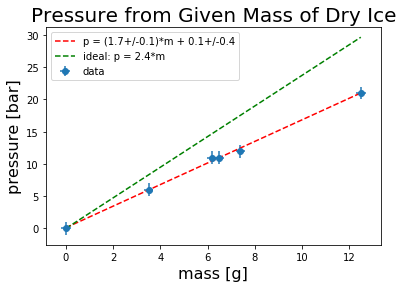

In [8]:
# Mass of dry ice [g] (includes zero data point by triviality)
m = np.array([6.3, 12.6, 7.5, 6.6, 3.8, 0])
# uncertainty [g]
sigma_m = 0.2
# time of sublimation before Parr reactor closed
tSub = np.array([30, 30, 30, 30, 75, 0])
# estimated loss of mass due to sublimation before Parr reactor closed
mSub = subRate*tSub
# corrected mass
m -= mSub

# gauge pressure after sublimation of dry ice [bar]
p = np.array([11,21,12,11, 6, 0])
# uncertainty [bar]
sigma_p = 1

# Linear regression
# We ignore the uncertainty in the mass since it is fractionally smaller (~ 2% vs. ~ 5% for p)
# Thus, m -> x and p -> y, so sigma = sigma_p
coeff, cov =  np.polyfit(m, p, 1, w=sigma_p*np.ones([len(m)]), cov=True)
a, b = coeff
sigma_a = np.sqrt(cov[0,0])
sigma_b = np.sqrt(cov[1,1])

# Plot
plt.figure()
plt.errorbar(m, p, xerr=sigma_m, yerr=sigma_p, label='data', fmt='o')
# linear distribution of masses
m_fit = np.linspace(np.min(m), np.max(m), 20)
p_fit =  a*m_fit + b
plt.plot(m_fit,p_fit, 'r--', label='p = (' + str(round(a,1)) +\
         '+/-' + str(round(sigma_a,1)) + ')*m + ' + str(round(b,1)) + '+/-' + str(round(sigma_b,1)))
# predicted pressure based on ideal gas law and full conversion of dry ice mass -> CO2 mass
n = m_fit/Mw_CO2 # number of moles of CO2
p_pred = n*R*T/V*Pa2bar
a_pred = R*T/(V*Mw_CO2)*Pa2bar
plt.plot(m_fit, p_pred, 'g--', label='ideal: p = ' + str(round(a_pred,1)) + '*m')

print('ratio = ' + str(np.mean(p_pred[1:]/p_fit[1:])))
# format plot
plt.legend(loc=2)    
plt.xlabel('mass [g]', fontsize=ax_fs)
plt.ylabel('pressure [bar]', fontsize=ax_fs)
plt.title('Pressure from Given Mass of Dry Ice', fontsize=t_fs)

# save figure
if savePlots:
    plt.tight_layout()
    saveName = 'dry_ice_m2p_parr_ideal'
    plt.savefig(saveFolder + saveName + ext)

We try another approach to account for the discrepancy in the pressure from the prediction by using actual data for the density of CO2 at the given pressure and temperature. In this way, we back-calculate the mass from the pressure, assuming a temperature of 25 C.

Multiply pressure by 1.2716190741551707 to get accurate results.


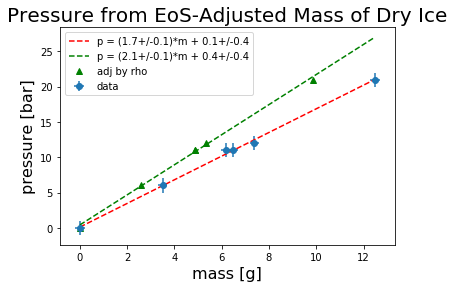

In [9]:
# co2 density [g/m^3] @ p, T = 25C from: http://www.peacesoftware.de/einigewerte/co2_e.html
rho = np.array([20.833E3,42.243E3,22.941E3,20.833E3,11.033E3,0])
m_rho = rho*V

# linear regression of predicted mass adjusted by correct co2 density
coeff_rho, covMat_rho = np.polyfit(m_rho, p, 1, w=sigma_p*np.ones([len(m_rho)]), cov=True)
a_rho, b_rho = coeff_rho
sigma_a_rho = np.sqrt(covMat_rho[0,0])
sigma_b_rho = np.sqrt(covMat_rho[1,1])

# plot
plt.figure()
plt.errorbar(m, p, xerr=sigma_m, yerr=sigma_p, label='data', fmt='o')
# linear distribution of masses
m_fit = np.linspace(np.min(m), np.max(m), 20)
p_fit =  a*m_fit + b
plt.plot(m_fit,p_fit, 'r--', label='p = (' + str(round(a,1)) +\
         '+/-' + str(round(sigma_a,1)) + ')*m + ' + str(round(b,1)) + '+/-' + str(round(sigma_b,1)))
p_rho_fit = a_rho*m_fit + b_rho
plt.plot(m_fit, p_rho_fit, 'g--', label='p = (' + str(round(a_rho,1)) +\
        '+/-' + str(round(sigma_a_rho,1)) + ')*m + ' + str(round(b_rho,1)) + '+/-' + str(round(sigma_b_rho,1)))
# plot adjusted mass
plt.plot(m_rho, p, 'g^', label='adj by rho')
# format plot
plt.legend(loc=2)    
plt.xlabel('mass [g]', fontsize=ax_fs)
plt.ylabel('pressure [bar]', fontsize=ax_fs)
plt.title('Pressure from EoS-Adjusted Mass of Dry Ice', fontsize=t_fs)

# save figure
if savePlots:
    plt.tight_layout()
    saveName = 'dry_ice_m2p_parr_adj_m'
    plt.savefig(saveFolder + saveName + ext)
    
# print appropriate conversion
conversion = a_rho / a
print('Multiply pressure by ' + str(conversion) + ' to get accurate results.')

### January 17, 2019

Correcting calibration to match EoS-adjusted values of the pressure, having observed that they give closer alignment with Dow's data.

In [10]:
m/V/1E3

array([26.52360515, 53.56223176, 31.67381974, 27.8111588 , 15.02145923,
        0.        ])

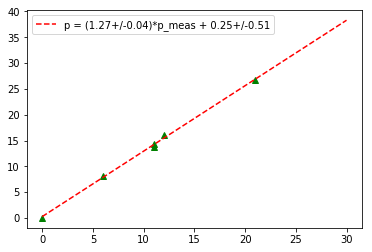

In [11]:
p_rho = np.array([13.7, 26.65, 16.15, 14.3, 8.08, 0])

# linear regression 
coeffs, covMat = np.polyfit(p, p_rho, 1, w=0.5*np.ones([len(p)]), cov=True)
conv, bias = coeffs
sigma_conv = np.sqrt(covMat[0,0])
sigma_bias = np.sqrt(covMat[1,1])

p_arr = np.linspace(0,30,100)
p_fit = conv*p_arr + bias
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(p, p_rho, 'g^')
ax.plot(p_arr, p_fit, 'r--', label='p = (' + str(round(conv,2)) + '+/-' + str(round(sigma_conv,2)) + ')*p_meas + ' + \
        str(round(bias,2)) + '+/-' + str(round(sigma_bias,2)))
ax.legend(loc='best')

Text(0,0.5,'actual pressure [bar]')

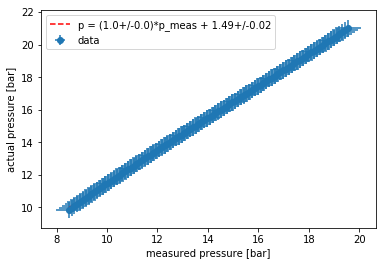

In [12]:
# calculate rho using 0.91*1.26*p on http://www.peacesoftware.de/einigewerte/co2_e.html
rho = 1E3*np.array([24.2058, 49.8008, 26.65108, 24.2058, 12.7637, 0])
m_rho = rho*V

m_fit = np.linspace(0, 15, 100)
# interpolation 
f = interp1d(m_fit, a*m_fit + b)
f_rho = interp1d(np.unique(m_rho), np.unique(p), kind="cubic")

# linearly spaced masses
m_arr = np.linspace(5, min(np.max(m_rho),np.max(m)),100)

# compute data from fit
p_fit = f(m_arr)
p_rho_fit = f_rho(m_arr)

# linear regression
coeffs, covMat = np.polyfit(p_fit, p_rho_fit, 1, w=0.5*np.ones([len(p_fit)]), cov=True)
conv, bias = coeffs
sigma_conv = np.sqrt(covMat[0,0])
sigma_bias = np.sqrt(covMat[1,1])

# calculate fit
p_est = conv*p_fit + bias

# plot the two pressures
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(p_fit, p_rho_fit, xerr=0.5*np.ones([len(p_fit)]), yerr=0.5*np.ones([len(p_rho_fit)]), label='data', fmt='o')
ax.plot(p_fit, p_est, 'r--', label='p = (' + str(round(conv,2)) + '+/-' + str(round(sigma_conv,2)) + ')*p_meas + ' + \
        str(round(bias,2)) + '+/-' + str(round(sigma_bias,2)))
ax.legend(loc='best')
ax.set_xlabel('measured pressure [bar]')
ax.set_ylabel('actual pressure [bar]')


In [13]:
p*0.91*1.26

array([12.6126, 24.0786, 13.7592, 12.6126,  6.8796,  0.    ])

In [14]:
rho = 1E-3*np.array([24.2058, 49.8008, 26.65108, 24.2058, 12.7637, 0])

### December 5, 2018
Correct measured pressure with the conversion found in "calibrate_span_pressure_gauge.ipynb"

In [15]:
def convert_p_span(p_span, sigma_p_span=None):
    """
    Converts the pressure given by the Span pressure gauge to the actual pressure
    based on the results of "calibrate_span_pressure_gauge.ipynb".
    """
    # conversion factor from calibrate_span_pressure_gauge.ipynb
    conv = 1.43
    sigma_conv = 0.16
    # convert pressure
    p = conv*p_span
    # if no uncertainty given
    if sigma_p_span is None:
        sigma_p = sigma_conv*p_span
    else:
        sigma_p = np.sqrt((sigma_conv*p_span)**2 + (conv*sigma_p_span)**2)
    
    return p, sigma_p

Analyze data now with corrected pressure readings.

In [16]:
convert_p_span(10, 1)

(14.299999999999999, 2.1459030733003766)

ratio = 0.9739535358079369


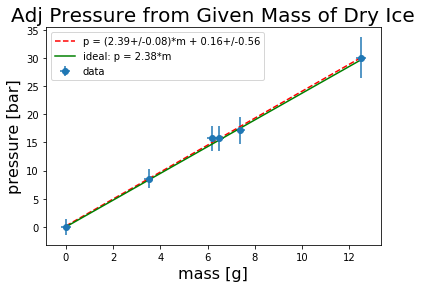

In [17]:
# correct pressure and uncertainty
p_corr, sigma_p_corr = convert_p_span(p, sigma_p_span=sigma_p)

# Linear regression
# We ignore the uncertainty in the mass since it is fractionally smaller (~ 2% vs. ~ 5% for p)
# Thus, m -> x and p -> y, so sigma = sigma_p
coeff, cov =  np.polyfit(m, p_corr, 1, w=sigma_p*np.ones([len(m)]), cov=True)
a, b = coeff
sigma_a = np.sqrt(cov[0,0])
sigma_b = np.sqrt(cov[1,1])

# Plot
plt.figure()
plt.errorbar(m, p_corr, xerr=sigma_m, yerr=sigma_p_corr, label='data', fmt='o')
# linear distribution of masses
m_fit = np.linspace(np.min(m), np.max(m), 20)
p_fit =  a*m_fit + b
plt.plot(m_fit,p_fit, 'r--', label='p = (' + str(round(a,2)) +\
         '+/-' + str(round(sigma_a,2)) + ')*m + ' + str(round(b,2)) + '+/-' + str(round(sigma_b,2)))
# predicted pressure based on ideal gas law and full conversion of dry ice mass -> CO2 mass
n = m_fit/Mw_CO2 # number of moles of CO2
p_pred = n*R*T/V*Pa2bar
a_pred = R*T/(V*Mw_CO2)*Pa2bar
plt.plot(m_fit, p_pred, 'g-', label='ideal: p = ' + str(round(a_pred,2)) + '*m')

print('ratio = ' + str(np.mean(p_pred[1:]/p_fit[1:])))
# format plot
plt.legend(loc='best')    
plt.xlabel('mass [g]', fontsize=ax_fs)
plt.ylabel('pressure [bar]', fontsize=ax_fs)
plt.title('Adj Pressure from Given Mass of Dry Ice', fontsize=t_fs)

# save figure
if savePlots:
    plt.tight_layout()
    saveName = 'dry_ice_m2p_parr_adj_p'
    plt.savefig(saveFolder + saveName + ext)

We also make a plot with both adjusted mass (from equation of state of CO2) and adjusted pressure (from calibration).

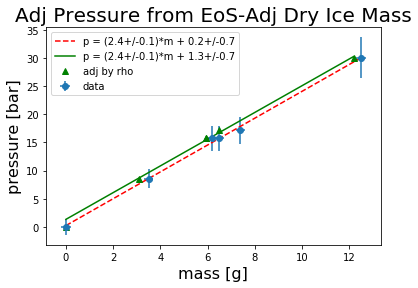

In [18]:
# correct pressure and uncertainty
p_corr, sigma_p_corr = convert_p_span(p, sigma_p_span=sigma_p)

# co2 density [g/m^3] @ p, T = 25C from: http://www.peacesoftware.de/einigewerte/co2_e.html
rho = np.array([30.804E3,64.273E3,33.818E3,30.804E3,15.994E3,0])

# rho = 1E3*np.array([22.61448854936, 46.17644191878, 24.88444205768, 22.61448854936, 11.91944190629, 0])
# rho = 1E3*np.array([23.8896, 49.0694, 26.28218, 23.89574834036, 12.5569775, 0])
rho = 1E3*np.array([25.3602380842, 52.2389261665, 27.87980518468,  25.3602380842, 13.28568558128, 0])

m_rho = rho*V

# Linear regression
# We ignore the uncertainty in the mass since it is fractionally smaller (~ 2% vs. ~ 5% for p)
# Thus, m -> x and p -> y, so sigma = sigma_p
coeff, cov =  np.polyfit(m, p_corr, 1, w=sigma_p_corr*np.ones([len(m)]), cov=True)
a, b = coeff
sigma_a = np.sqrt(cov[0,0])
sigma_b = np.sqrt(cov[1,1])

# linear regression of predicted mass adjusted by correct co2 density
coeff_rho, covMat_rho = np.polyfit(m_rho, p_corr, 1, w=sigma_p_corr, cov=True)
a_rho, b_rho = coeff_rho
sigma_a_rho = np.sqrt(covMat_rho[0,0])
sigma_b_rho = np.sqrt(covMat_rho[1,1])

# plot
plt.figure()
plt.errorbar(m, p_corr, xerr=sigma_m, yerr=sigma_p_corr, label='data', fmt='o')
# linear distribution of masses
m_fit = np.linspace(np.min(m), np.max(m), 20)
p_fit =  a*m_fit + b
plt.plot(m_fit,p_fit, 'r--', label='p = (' + str(round(a,1)) +\
         '+/-' + str(round(sigma_a,1)) + ')*m + ' + str(round(b,1)) + '+/-' + str(round(sigma_b,1)))
# linear distribution of masses
m_fit = np.linspace(np.min(m_rho), np.max(m_rho), 20)
p_rho_fit = a_rho*m_fit + b_rho
plt.plot(m_fit, p_rho_fit, 'g-', label='p = (' + str(round(a_rho,1)) +\
        '+/-' + str(round(sigma_a_rho,1)) + ')*m + ' + str(round(b_rho,1)) + '+/-' + str(round(sigma_b_rho,1)))
# plot adjusted mass
plt.plot(m_rho, p_corr, 'g^', label='adj by rho')
# format plot
plt.legend(loc='best')    
plt.xlabel('mass [g]', fontsize=ax_fs)
plt.ylabel('pressure [bar]', fontsize=ax_fs)
plt.title('Adj Pressure from EoS-Adj Dry Ice Mass', fontsize=t_fs)

# save figure
if savePlots:
    plt.tight_layout()
    saveName = 'dry_ice_m2p_parr_adj_m'
    plt.savefig(saveFolder + saveName + ext)

## Measuring Pressure without Leak

Previous measurements were performed in a Parr reactor known to have a small leak, leading to high inaccuracies in the conversion from measured to actual pressure. The following data were obtained after the leak in the Parr reactor was sealed.

In [19]:
# Mass of dry ice [g] (includes zero data point by triviality)
m0 = np.array([0, 4.60, 7.19, 5.65, 9.98, 15.10, 18.65, 11.07])
# uncertainty [g]
sigma_m = 0.1
# time of sublimation before Parr reactor closed
tSub = np.array([0, 150, 55, 55, 60, 50, 75, 55])
# estimated loss of mass due to sublimation before Parr reactor closed
mSub = subRate*tSub
# corrected mass
m = m0 - mSub

# gauge pressure after sublimation of dry ice [bar]
p = np.array([0, 6, 12.5, 9, 17, 25, 26.5, 18.5])
# uncertainty [bar]
sigma_p = 1

# Linear regression
# We ignore the uncertainty in the mass since it is fractionally smaller (~ 2% vs. ~ 5% for p)
# Thus, m -> x and p -> y, so sigma = sigma_p
coeff, cov =  np.polyfit(m, p, 1, w=sigma_p*np.ones([len(m)]), cov=True)
a, b = coeff
sigma_a = np.sqrt(cov[0,0])
sigma_b = np.sqrt(cov[1,1])



To determine the conversion from measured pressure to actual, we calculate the density of CO2 expected given the mass and use the equation of state to determine the corresponding pressure (at T = 25 C).

In [20]:
rho = m/V
rho

array([    0.        , 17167.38197425, 29914.16309013, 23304.72103004,
       41802.5751073 , 63948.49785408, 78755.36480687, 46566.52360515])

ratio = 1.2970105009401345
error = 0.10929477299930104


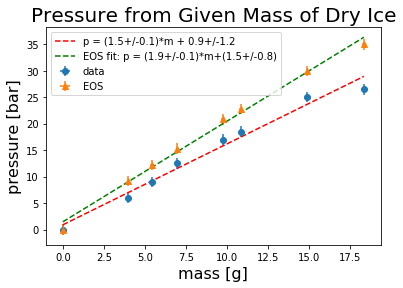

In [21]:
# pressure predicted from CO2 equation of state at T = 25C from: http://www.peacesoftware.de/einigewerte/co2_e.html
pEOS = np.array([0, 9.19, 15.31, 12.17, 20.82, 29.9, 34.95, 22.77])

# linear regression of equation of state data
coeffEOS, covEOS = np.polyfit(m, pEOS, 1, w=sigma_p*np.ones([len(m)]), cov=True)
aEOS, bEOS = coeffEOS
sigma_aEOS = np.sqrt(covEOS[0,0])
sigma_bEOS = np.sqrt(covEOS[1,1])

# Plot
plt.figure()

# plot data
plt.errorbar(m, p, xerr=sigma_m, yerr=sigma_p, label='data', fmt='o')
# linear fit
m_fit = np.linspace(np.min(m), np.max(m), 20)
p_fit =  a*m_fit + b
plt.plot(m_fit,p_fit, 'r--', label='p = (' + str(round(a,1)) +\
         '+/-' + str(round(sigma_a,1)) + ')*m + ' + str(round(b,1)) + '+/-' + str(round(sigma_b,1)))

# predicted pressure based on equation of state
plt.errorbar(m, pEOS, xerr=sigma_m, yerr=sigma_p, label='EOS', fmt='^')
# linear fit
pEOS_fit = aEOS*m_fit + bEOS
plt.plot(m_fit, pEOS_fit, 'g--', label='EOS fit: p = (' + str(round(aEOS,1)) + '+/-' + \
         str(round(sigma_aEOS,1)) + ')*m+(' + str(round(bEOS,1)) + '+/-' + str(round(sigma_bEOS,1)) + ')')

print('ratio = ' + str(np.mean(pEOS[1:]/p[1:])))
print('error = ' + str(np.std(pEOS[1:]/p[1:])))
# format plot
plt.legend(loc='best')    
plt.xlabel('mass [g]', fontsize=ax_fs)
plt.ylabel('pressure [bar]', fontsize=ax_fs)
plt.title('Pressure from Given Mass of Dry Ice', fontsize=t_fs)

savePlots = False
# save figure
if savePlots:
    plt.tight_layout()
    saveName = 'dry_ice_m2p_parr_ideal'
    plt.savefig(saveFolder + saveName + ext)
